In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import cross_validation, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

actor_full = pd.read_pickle('joint_df.pickle')
actor_full.head()

/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ian/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,movie,release,actor,rank,studio,adjusted_gross,unadjusted_gross,actor_id,Canadian male voice actors,21st-century Australian actresses,...,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,release_day,release_date,production_budget,domestic_gross,worldwide_gross
0,(500) Days of Summer,2009,Chloe Moretz,11,FoxS,37749800,32391374,chloemoretz,False,False,...,False,False,False,0,4540 days,2009-07-17,2009-07-17,7500000,32391374,59101642
1,(500) Days of Summer,2009,Clark Gregg,7,FoxS,37749800,32391374,clarkgregg,False,False,...,False,False,False,1,17273 days,2009-07-17,2009-07-17,7500000,32391374,59101642
2,(500) Days of Summer,2009,Minka Kelly,-,FoxS,37749800,32391374,minkakelly,False,False,...,False,False,False,0,10615 days,2009-07-17,2009-07-17,7500000,32391374,59101642
3,(500) Days of Summer,2009,Zooey Deschanel,10,FoxS,37749800,32391374,zooeydeschanel,False,False,...,False,False,False,0,10774 days,2009-07-17,2009-07-17,7500000,32391374,59101642
4,10 Cloverfield Lane,2016,Mary Elizabeth Winstead,4,Par.,68379000,68378983,maryelizabethwinstead,False,False,...,False,False,False,0,11426 days,2016-03-11,2016-03-11,5000000,69793284,101493284


In [2]:
actor_data = actor_full.drop(['rank','unadjusted_gross','actor_id'], axis=1)

# drop the NaN's
pre_drop_nans = len(actor_data)
actor_data.dropna(inplace=True)
print'Dropped %i rows with NaNs. There are %i left.' % (pre_drop_nans-len(actor_data), len(actor_data))
print '\n* * *\n'

# convert times to yearly
secs_per_year = 31622400.0
actor_data.age_on_release = actor_data.age_on_release.dt.total_seconds()/secs_per_year

for col in ['bday']:
    actor_data[col] = actor_data[col].dt.year

# calculate ROI
actor_data['roi'] = actor_data.domestic_gross / actor_data.production_budget
    
# filter out crazy erroneous stuff
# by eye looking at pre-filtered scatterplots
pre_filter_len = len(actor_data)
actor_data = actor_data[(actor_data.age_on_release < 100) 
    & (actor_data.bday > 1920) & (actor_data.release < 2016)]
print'Filtered out %i rows with impossible values. There are %i rows left.' % (
    pre_filter_len-len(actor_data), len(actor_data))
print '\n* * *\n\n'
    
readable_cols = ['actor','bday','movie','release','adjusted_gross','production_budget','age_on_release','male_txt']
actor_data[readable_cols].head()

Dropped 0 rows with NaNs. There are 9342 left.

* * *

Filtered out 84 rows with impossible values. There are 9258 rows left.

* * *




,actor,bday,movie,release,adjusted_gross,production_budget,age_on_release,male_txt
0,Chloe Moretz,1997,(500) Days of Summer,2009,37749800,7500000,12.404372,0
1,Clark Gregg,1962,(500) Days of Summer,2009,37749800,7500000,47.193989,1
2,Minka Kelly,1980,(500) Days of Summer,2009,37749800,7500000,29.002732,0
3,Zooey Deschanel,1980,(500) Days of Summer,2009,37749800,7500000,29.437158,0
5,Glenn Close,1947,102 Dalmatians,2000,107144200,85000000,53.571038,0


In [3]:
# set movies_count for each actor
actor_data.set_index('actor', inplace=True)
actor_data['movies_count'] = actor_data.reset_index().groupby('actor').movie.apply(pd.Series.count)

actor_data.reset_index(inplace=True)
actor_data[readable_cols].head(10)

,actor,bday,movie,release,adjusted_gross,production_budget,age_on_release,male_txt
0,Chloe Moretz,1997,(500) Days of Summer,2009,37749800,7500000,12.404372,0
1,Clark Gregg,1962,(500) Days of Summer,2009,37749800,7500000,47.193989,1
2,Minka Kelly,1980,(500) Days of Summer,2009,37749800,7500000,29.002732,0
3,Zooey Deschanel,1980,(500) Days of Summer,2009,37749800,7500000,29.437158,0
4,Glenn Close,1947,102 Dalmatians,2000,107144200,85000000,53.571038,0
5,Ioan Gruffudd,1973,102 Dalmatians,2000,107144200,85000000,27.073770,1
6,Giovanni Ribisi,1974,10th & Wolf,2006,72700,8000000,31.603825,1
7,James Marsden,1973,10th & Wolf,2006,72700,8000000,32.846995,1
8,Piper Perabo,1976,10th & Wolf,2006,72700,8000000,29.734973,0
9,Val Kilmer,1959,10th & Wolf,2006,72700,8000000,46.535519,1


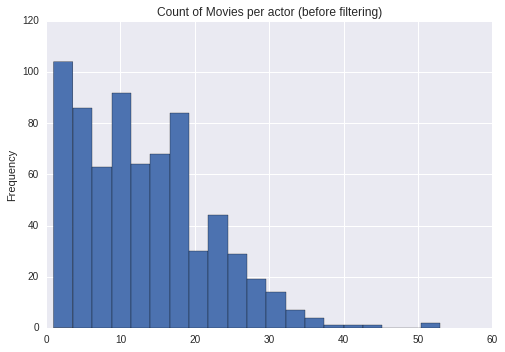

In [4]:
actor_data.reset_index().groupby('actor').movies_count.first().plot.hist(
    title='Count of Movies per actor (before filtering)', bins=20);

In [5]:
# only include actors with over 5 movies ( <=5 means not enough data to be useful)
pre_filter_len = len(actor_data)
actor_data = actor_data[actor_data.movies_count > 5]
print 'removed %i actors, %i left' % (pre_filter_len-len(actor_data), len(actor_data))

removed 475 actors, 8783 left


In [6]:
# drop the text columns (except for actor)
actor_data.drop(['movie','studio'], axis=1, inplace=True)

# keep only the int-formatted release year, 'release'
actor_data.drop(['release_day','release_date'], axis=1, inplace=True)

# # convert datetime/timedelta to numeric
# for col in actor_data.select_dtypes(exclude=['bool']).columns:
#     print '(before)', col, '\t\t', actor_data[col].dtype
#     actor_data[col] = pd.to_numeric(actor_data[col])
#     print '(after )', col, '\t\t', actor_data[col].dtype, '\n'

actor_data.head()

,actor,release,adjusted_gross,Canadian male voice actors,21st-century Australian actresses,Canadian male television actors,English people of Irish descent,Commanders of the Order of the British Empire,Wikipedia protected pages without expiry,American atheists,...,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,production_budget,domestic_gross,worldwide_gross,roi,movies_count
0,Chloe Moretz,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,0,12.404372,7500000,32391374,59101642,4.318850,15
1,Clark Gregg,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,1,47.193989,7500000,32391374,59101642,4.318850,17
3,Zooey Deschanel,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,0,29.437158,7500000,32391374,59101642,4.318850,20
4,Glenn Close,2000,107144200,False,False,False,False,False,False,False,...,True,False,False,0,53.571038,85000000,66941559,66941559,0.787548,12
5,Ioan Gruffudd,2000,107144200,False,False,False,False,False,False,False,...,False,False,False,1,27.073770,85000000,66941559,66941559,0.787548,10


In [7]:
# actor_data.to_pickle('actor_data_cleaned.pickle')

In [8]:
# The convenience fn train_test_split() randomly splits X and y into train and test.
# For results to be reproducible, set the random seed

dependent_var = 'roi'

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data[dependent_var],
    test_size=0.3, 
    random_state=0)

print 'Attempting to predict y="%s"\n\n' % y_train.name

non_bool_columns = [col for col in X_train.columns if X_train[col].dtype != 'bool']

# look at all the non-bool features
print 'non-bool features in X:\n'
for col in non_bool_columns:
    print col, '\t', X_train[col].dtype

print '\n\nthey look like:\n'
X_train[non_bool_columns].head()

Attempting to predict y="roi"


non-bool features in X:

release 	int64
bday 	int64
male_txt 	float64
age_on_release 	float64
movies_count 	int64


they look like:



,release,bday,male_txt,age_on_release,movies_count
3279,1999,1943,1,56.226776,33
9156,2006,1972,0,33.480874,8
8986,2006,1986,0,19.153005,6
5263,2009,1993,0,15.229508,8
2989,2005,1986,0,18.934426,10


In [9]:
lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=3000)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=3000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [10]:
def make_coef_df(model, X_train, y_train, significance_thresh=0):
    print 'alpha (aka lambda) for model: %f' % model.alpha_
    print 'intercept for model: %f' % model.intercept_
    print 'R-squared (unadjusted??) of model on training set:', model.score(X_train, y_train)

    significant_columns = np.where(abs(model.coef_) > significance_thresh)[0]
    
    print '\ngot %i significant columns (abs is > %f) out of %i' % (
        len(significant_columns), significance_thresh, len(model.coef_))

    coef_df = pd.DataFrame(
        [(model.coef_[idx], X_train.columns[idx]) for idx in significant_columns], 
        index=significant_columns, columns=['coef','col_name'])

    # sort coefficients by absolute value
    coef_df = coef_df.loc[coef_df.coef.abs().sort_values(ascending=False).index]
    return coef_df

# top 20
coef_df = make_coef_df(lasso_model, X_train, y_train)
coef_df.head(20)

alpha (aka lambda) for model: 0.002329
intercept for model: 201.117321
R-squared (unadjusted??) of model on training set: 0.0477364584439

got 3 significant columns (abs is > 0.000000) out of 344


,coef,col_name
69,0.163079,LGBT rights activists from the United States
0,-0.099378,release
342,-0.002122,age_on_release


In [11]:
for interest in ['People from Manhattan'] + non_bool_columns:
    idx = X_train.columns.get_loc(interest)
    print lasso_model.coef_[idx], interest

-0.0 People from Manhattan
-0.099378055534 release
0.0 bday
-0.0 male_txt
-0.00212150679662 age_on_release
-0.0 movies_count


In [12]:
# my columns of interest, besides those bools
coef_df[coef_df.col_name.isin(non_bool_columns)]

,coef,col_name
0,-0.099378,release
342,-0.002122,age_on_release


In [13]:
# most positive betas
coef_df.sort_values('coef', ascending=False).head(10)

,coef,col_name
69,0.163079,LGBT rights activists from the United States
342,-0.002122,age_on_release
0,-0.099378,release


In [14]:
# most negative betas
coef_df.sort_values('coef').head(10)

,coef,col_name
0,-0.099378,release
342,-0.002122,age_on_release
69,0.163079,LGBT rights activists from the United States


# Try a much simpler model

In [15]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data[['bday','age_on_release','male_txt']], 
    actor_data[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

alpha (aka lambda) for model: 0.000036
intercept for model: 239.615926
R-squared (unadjusted??) of model on training set: 0.0499498202654

got 3 significant columns (abs is > 0.000000) out of 3


,coef,col_name
1,-0.132821,age_on_release
0,-0.118354,bday
2,0.035907,male_txt


**Exploratory plots**

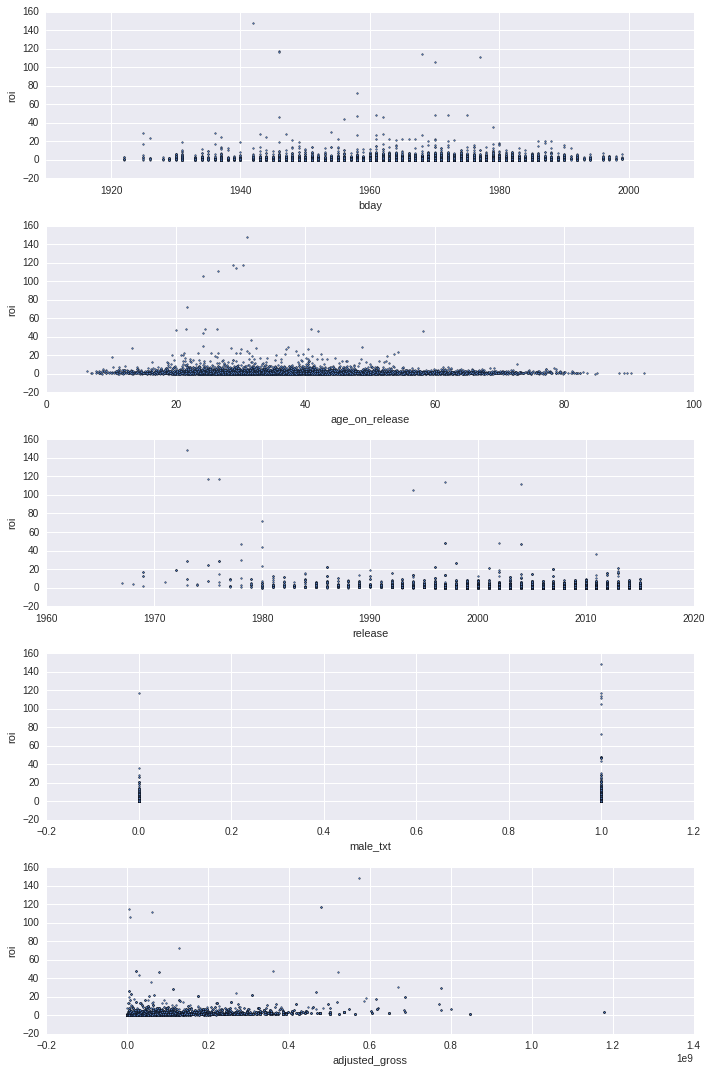

In [16]:
cols_to_plot = ['bday','age_on_release','release','male_txt','adjusted_gross']

plt.figure(figsize=(10,15))

for idx, col in enumerate(cols_to_plot):
    ax = plt.subplot(len(cols_to_plot),1,idx+1)
    plt.xlabel(col)
    actor_data.plot.scatter(col, dependent_var, ax=ax, s=3)
    
plt.tight_layout()

# Warning: these plots are by movie-and-actor rows. A given movie and actor will have multiple rows. They should probably be grouped first...

Count: 5925 males, 2858 females
Male   mean adj gross: 1
Female mean adj gross: 1
men gross 0 more than women (diff of means)


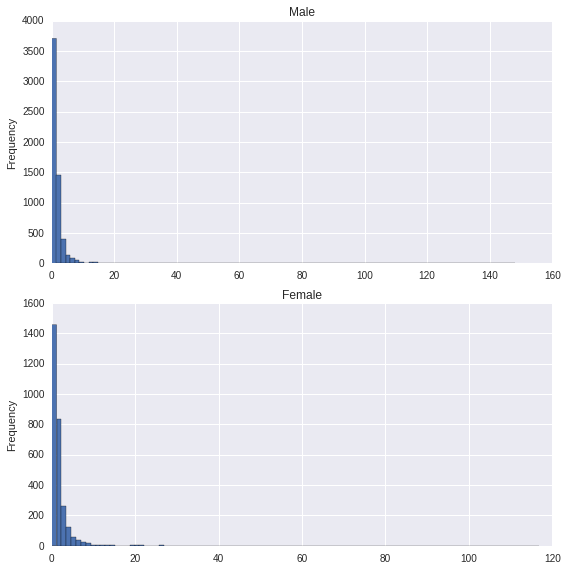

In [17]:
no_bins = 100
plt.figure(figsize=(8,8))

males_adj_gross = actor_data[actor_data.male_txt==1][dependent_var]
females_adj_gross = actor_data[actor_data.male_txt==0][dependent_var]

print 'Count: %i males, %i females' % (len(males_adj_gross), len(females_adj_gross))
print 'Male   mean adj gross: %i\nFemale mean adj gross: %i' % (males_adj_gross.mean(), females_adj_gross.mean())
print 'men gross %i more than women (diff of means)' % (males_adj_gross.mean() - females_adj_gross.mean())
ax = plt.subplot(2,1,1)
males_adj_gross.plot.hist(bins=no_bins, title='Male')

ax = plt.subplot(2,1,2)
females_adj_gross.plot.hist(bins=no_bins, ax=ax, title='Female')

plt.tight_layout()

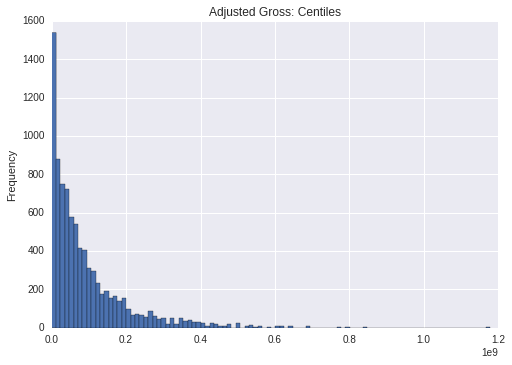

In [18]:
actor_data.adjusted_gross.plot.hist(bins=100)
plt.title('Adjusted Gross: Centiles');

min:6
max:92
mean:38


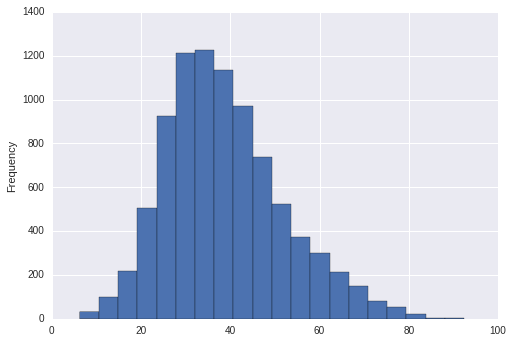

In [19]:
print 'min:%i\nmax:%i\nmean:%i' % (
    actor_data.age_on_release.min(), actor_data.age_on_release.max(), actor_data.age_on_release.mean())

actor_data.age_on_release.plot.hist(bins=20);

women median age on movie release 31
men median age on movie release  39
* * * 
women mean age on movie release 33
men mean age on movie release  41



Distribution of actor ages on movie release date by gender


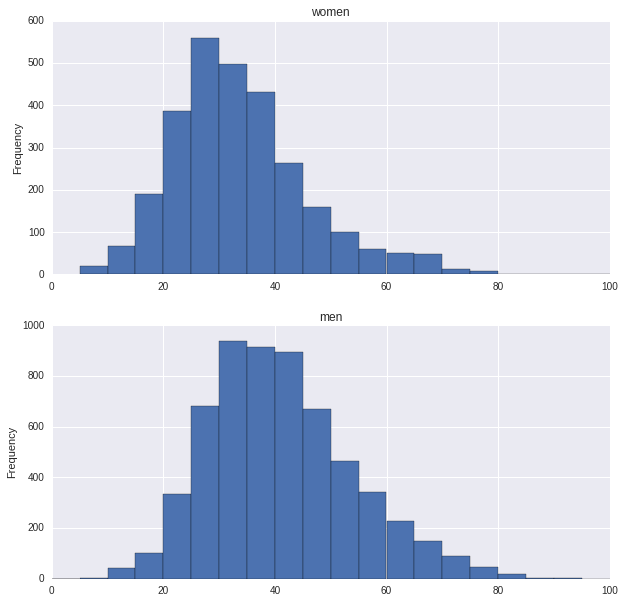

In [20]:
women = actor_data[actor_data.male_txt == 0].age_on_release
men = actor_data[actor_data.male_txt == 1].age_on_release

print 'women median age on movie release %i\nmen median age on movie release  %i' % (women.median(), men.median())
print '* '*3
print 'women mean age on movie release %i\nmen mean age on movie release  %i' % (women.mean(), men.mean())
print '\n\n'
print 'Distribution of actor ages on movie release date by gender'

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
women.plot.hist(bins=20, ax=ax, title='women', range=[0,100])
ax = plt.subplot(2,1,2)
men.plot.hist(bins=20, ax=ax, title='men', range=[0,100]);

**Try polynomial features on age/date**

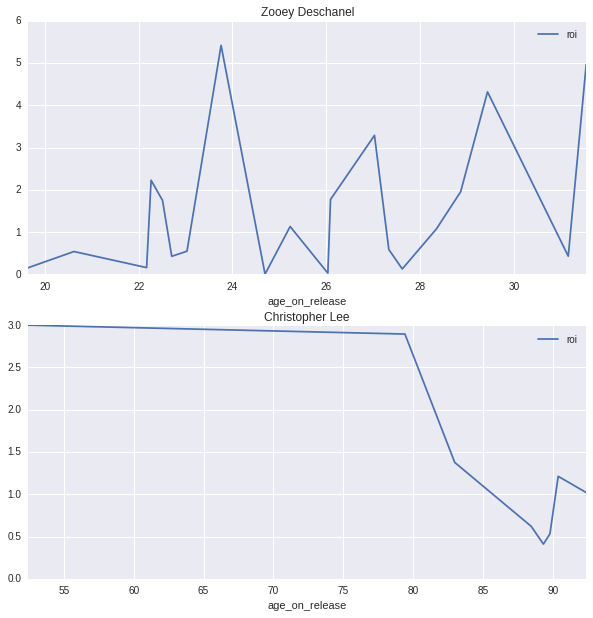

In [41]:
def plot_age_curve(actor_names, figsize=(10,10), y='production_budget'):
    """df is a dataframe with actor data, indexed by actor name"""
    plt.figure(figsize=figsize)
    
    if isinstance(actor_names, str):
        actor_names = [actor_names]
    
    actor_df = actor_data.set_index('actor')
    
    for idx, actor_name in enumerate(actor_names):
        ax = plt.subplot(len(actor_names), 1, idx+1)
        fig = actor_df.loc[actor_name].groupby('age_on_release', as_index=False).sum().plot(
            x='age_on_release', y=y, title=actor_name, ax=ax)
    
    return ax

plot_age_curve(['Zooey Deschanel','Christopher Lee'], y='roi');

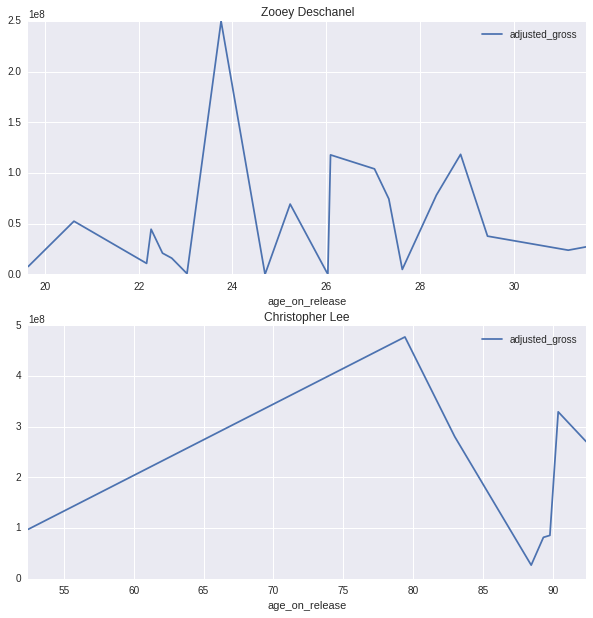

In [22]:
plot_age_curve(['Zooey Deschanel','Christopher Lee'], y='adjusted_gross');

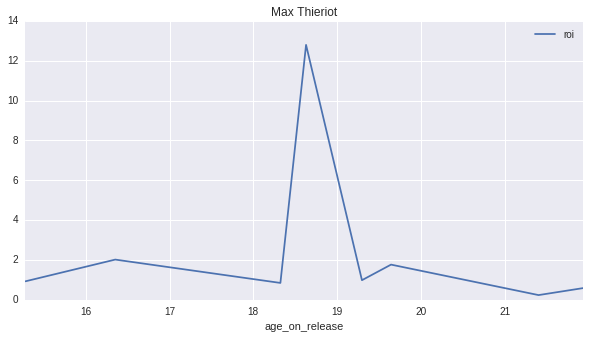

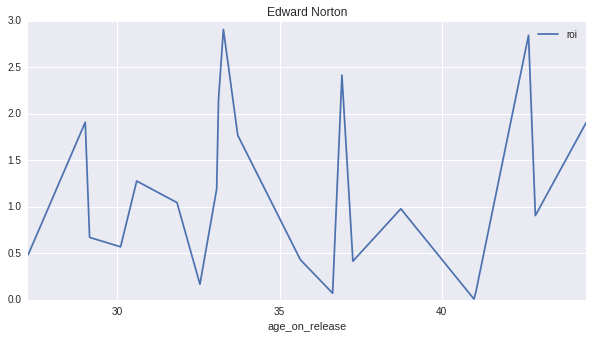

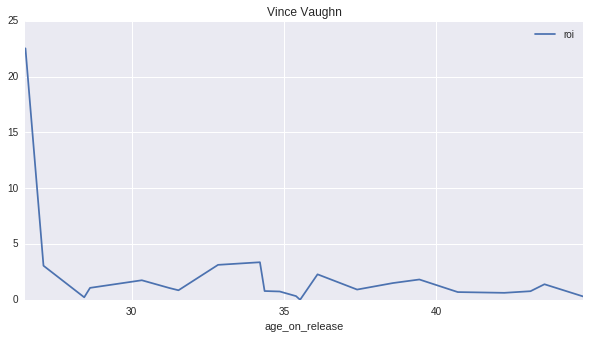

In [40]:
# plot some random age curves
for name in np.random.choice(actor_data.actor.unique(), size=3, replace=False):
    plot_age_curve(name, figsize=(10,5), y='roi')

In [39]:
poly_features = ['bday','age_on_release','release','male_txt']

X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(
    actor_data[poly_features], 
    actor_data.production_budget, 
    test_size=0.3, 
    random_state=0)

poly_lasso = make_pipeline(PolynomialFeatures(), 
    linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000))

poly_lasso.fit(X_train3, y_train3)

lasso3 = poly_lasso.get_params()['lassocv']
poly_feat3 = poly_lasso.get_params()['polynomialfeatures']

print lasso3.coef_
print poly_feat3.powers_

[  0.00000000e+00   1.71922314e+04   1.54906949e+05   0.00000000e+00
   0.00000000e+00   8.18742596e+01   3.12896110e+02   3.02579963e+02
   5.66253889e+02   1.33240338e+03   1.37016390e+02   1.61063863e+05
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]]


In [25]:
def get_poly_labels(labels, poly_obj):
    final_labels = []
    separator = '_x_'
    for power_list in poly_obj.powers_:
        s = ''
        for label, power in zip(labels, power_list):
            if power != 0:
                s += "%s_p%i%s" % (label, power, separator)
        if s == '':
            final_labels.append('1')
        else:
            final_labels.append(s[:-len(separator)])
    
    return final_labels
        
poly_labels = get_poly_labels(poly_features, poly_feat3)
pd.DataFrame(zip(poly_labels, list(lasso3.coef_)), columns=['feature','coef']).sort_values('coef', ascending=False)

,feature,coef
11,age_on_release_p1_x_male_txt_p1,161063.863026
2,age_on_release_p1,154906.948951
1,bday_p1,17192.231399
9,age_on_release_p2,1332.403377
8,bday_p1_x_male_txt_p1,566.253889
6,bday_p1_x_age_on_release_p1,312.896110
7,bday_p1_x_release_p1,302.579963
10,age_on_release_p1_x_release_p1,137.016390
5,bday_p2,81.874260
0,1,0.000000


In [26]:
print 'R-squared score:'
poly_lasso.score(X_train3, y_train3)

R-squared score:


0.070427987386787683

From the coefficients above, it looks like these combined features are useful:

```
age_on_release * male_txt
age_on_release^2
bday * male_txt
```

So I'll manually generate them:

In [27]:
actor_data_eng = actor_data.copy()

actor_data_eng['age_on_release_x_male_txt'] = actor_data_eng.age_on_release * actor_data_eng.male_txt
actor_data_eng['age_on_release_p2'] = actor_data_eng.age_on_release**2
actor_data_eng['bday_x_male_txt'] = actor_data_eng.bday * actor_data_eng.male_txt

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data_eng.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data_eng[dependent_var],
    test_size=0.3, 
    random_state=0)

print len(X_train), len(X_test)
print '\n\n Features:\n'
print [col for col in X_train.columns if X_train[col].dtype != 'bool']
print '\nBools\n'
print [col for col in X_train.columns if X_train[col].dtype == 'bool']

y_train.head()

6148 2635


 Features:

['release', 'bday', 'male_txt', 'age_on_release', 'movies_count', 'age_on_release_x_male_txt', 'age_on_release_p2', 'bday_x_male_txt']

Bools

['Canadian male voice actors', '21st-century Australian actresses', 'Canadian male television actors', 'English people of Irish descent', 'Commanders of the Order of the British Empire', 'Wikipedia protected pages without expiry', 'American atheists', '1992 births', 'English male television actors', 'Best Supporting Actress Academy Award winners', 'Articles with unsourced statements from January 2016', 'Articles with unsourced statements from January 2015', 'Jewish American writers', 'Male actors from Texas', 'American impressionists (entertainers)', 'David di Donatello winners', '1963 births', 'Male actors from Los Angeles, California', 'American television actresses', 'Wikipedia indefinitely semi-protected biographies of living people', 'Human name disambiguation pages', 'Directors Guild of America Award winners', 'Page

3279    0.083664
9156    1.116012
8986    3.190681
5263    1.343452
2989    1.320214
Name: roi, dtype: float64

In [28]:
lasso_model_eng = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=3000)
lasso_model_eng.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=3000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [29]:
coef_df_eng = make_coef_df(lasso_model_eng, X_train, y_train, significance_thresh=0)
coef_df_eng.head(20)

alpha (aka lambda) for model: 0.002329
intercept for model: 201.117321
R-squared (unadjusted??) of model on training set: 0.0477364584439

got 3 significant columns (abs is > 0.000000) out of 347


,coef,col_name
69,0.163079,LGBT rights activists from the United States
0,-0.099378,release
342,-0.002122,age_on_release


# General women vs men budget:age curves (averaged across age)

Using each age as a whole number, compute the median production budget at that age for the given gender.

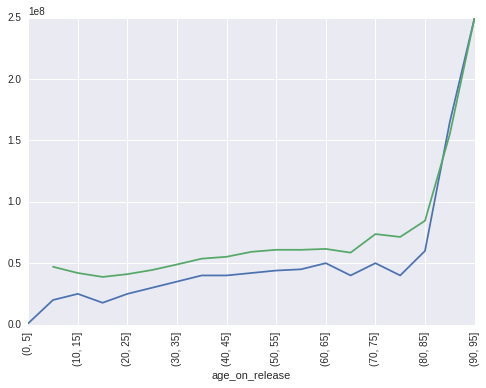

In [30]:
men = actor_data[actor_data.male_txt == 1].copy()
women = actor_data[actor_data.male_txt == 0].copy()

# Set to 5 for 5-year age bins
age_res = 5

for df in [men, women]:
    df.age_on_release = df.age_on_release.astype(int)
    df.age_on_release = pd.cut(x=df.age_on_release, bins=range(0,100,age_res))

def plot_overall_age_curve(df, how):
    if how == 'median':
        return df.groupby('age_on_release').median().production_budget.plot(rot=90)
    if how == 'mean':
        return df.groupby('age_on_release').mean().production_budget.plot(rot=90)
    
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(men, 'mean')

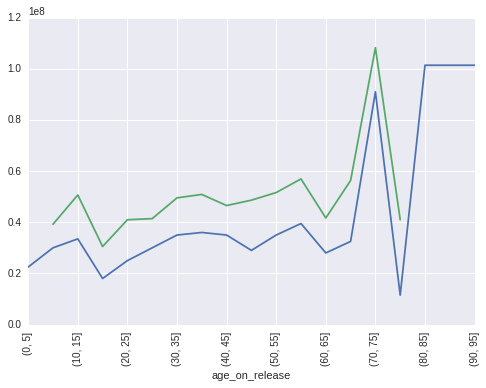

In [31]:
plot_overall_age_curve(women, 'median')
plot_overall_age_curve(women, 'mean')

Compare median of women and men

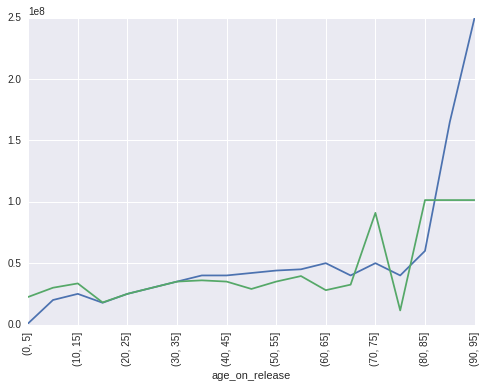

In [32]:
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(women, 'median')

# TODO: Try to get top billing, so you can differentiate main roles from supporting roles